In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np


from dotenv import load_dotenv
load_dotenv()
DATASET_PATH=os.getenv("DATASET_DIRECTORY")
CONFIG_DIRECTORY = os.getenv("CONFIG_DIRECTORY")
RADARHD_MODEL_STATE_DICT_PATH=os.getenv("RADARHD_MODEL_STATE_DICT_PATH")

sys.path.append("../")
from mmwave_radar_processing.config_managers.cfgManager import ConfigManager
from cpsl_datasets.cpsl_ds import CpslDS

from mmwave_model_integrator.input_encoders.radarhd_encoder import RadarHDEncoder
from mmwave_model_integrator.model_runner.radarhd_runner import RadarHDRunner
from mmwave_model_integrator.decoders.radarhd_decoder import RadarHDDecoder
from mmwave_model_integrator.ground_truth_encoders.radarHD_gt_encoder import RadarHDGTEncoder
from mmwave_model_integrator.analyzers.analyzer_rng_az_to_pc import AnalyzerRngAzToPC

from mmwave_model_integrator.plotting.plotter_rng_az_to_pc import PlotterRngAzToPC
from mmwave_model_integrator.plotting.movies_rng_az_to_pc import MovieGeneratorRngAzToPC
from mmwave_model_integrator.transforms.coordinate_transforms import polar_to_cartesian



In [2]:
cfg_manager = ConfigManager()

cfg_path = os.path.join(CONFIG_DIRECTORY,"RadarHD.cfg")
cfg_manager.load_cfg(cfg_path)
cfg_manager.compute_radar_perforance(profile_idx=0)

In [3]:

#load the dataset
dataset_name = "cpsl_RadarHD"
dataset_path = os.path.join(DATASET_PATH,"radarHD_comp_datasets",dataset_name)
dataset = CpslDS(
    dataset_path=dataset_path,
    radar_folder="radar_0",
    lidar_folder="lidar",
    camera_folder="camera",
    imu_orientation_folder="imu_data",
    imu_full_folder="imu_data_full"
)

found 303 radar samples
found 303 lidar samples
found 303 camera samples
found 303 imu (orientation only) samples
found 303imu (full data) samples
found 303 vehicle velocity samples


In [4]:
plotter = PlotterRngAzToPC()

input_encoder = RadarHDEncoder(
    config_manager=cfg_manager,
    range_max=10.8,
    num_range_bins=256,
    mag_threshold=0.05,
    num_az_angle_bins=64
)

ground_truth_encoder = RadarHDGTEncoder(
    max_range_m=10.8,
    num_range_bins=256,
    angle_range_rad=[np.deg2rad(-90),np.deg2rad(90)],
    num_angle_bins=512,
    max_angle_rad=np.deg2rad(70),
    x_max=10,
    y_max=10,
    z_max=0.3,
    z_min=-0.2
)

runner = RadarHDRunner(
    state_dict_path=RADARHD_MODEL_STATE_DICT_PATH,
    cuda_device="cuda:0"
)

prediction_decoder = RadarHDDecoder(
    max_range_m=10.8,
    num_range_bins=256,
    num_angle_bins=512
)

movie_generator = MovieGeneratorRngAzToPC(
    cpsl_dataset=dataset,
    plotter=plotter,
    input_encoder=input_encoder,
    model_runner=runner,
    prediction_decoder=prediction_decoder,
    ground_truth_encoder=ground_truth_encoder,
    temp_dir_path=os.getenv("MOVIE_TEMP_DIRECTORY")
)

analyzer = AnalyzerRngAzToPC(
    cpsl_dataset=dataset,
    input_encoder=input_encoder,
    model_runner=runner,
    prediction_decoder=prediction_decoder,
    ground_truth_encoder=ground_truth_encoder,
    temp_dir_path=os.getenv("ANALYZER_TEMP_DIRECTORY")
)

_ModelRunner: using CPU
found temp dir: /home/david/Downloads/radnav_temp_dir
clearing temp directory /home/david/Downloads/radnav_temp_dir


/home/david/.cache/pypoetry/virtualenvs/mmwave-model-integrator-S4Y7oiM5-py3.10/lib/python3.10/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [5]:
#encode 40 frames before the first encoding is available
i = 0
input_encoder.reset_history()
while (not input_encoder.full_encoding_ready) or (not ground_truth_encoder.full_encoding_ready):

    #get the radar data
    adc_cube = dataset.get_radar_data(idx=i)
    encoded_data = input_encoder.encode(adc_cube)

    #get the lidar data
    lidar_pc = dataset.get_lidar_point_cloud_raw(idx=0)
    grid = ground_truth_encoder.encode(lidar_pc)
    quantized_pc = ground_truth_encoder.grid_to_polar_points(grid)
    quantized_pc = polar_to_cartesian(quantized_pc)
    i+=1

pred = runner.make_prediction(encoded_data)
pc_cart = prediction_decoder.convert_polar_to_cartesian(
    prediction_decoder.decode(pred)
)

#accessing lidar ground truth output and encoding it
lidar_pc = dataset.get_lidar_point_cloud_raw(idx=i-1)
grid = ground_truth_encoder.encode(lidar_pc)
quantized_pc = ground_truth_encoder.grid_to_polar_points(grid)
quantized_pc = polar_to_cartesian(quantized_pc)

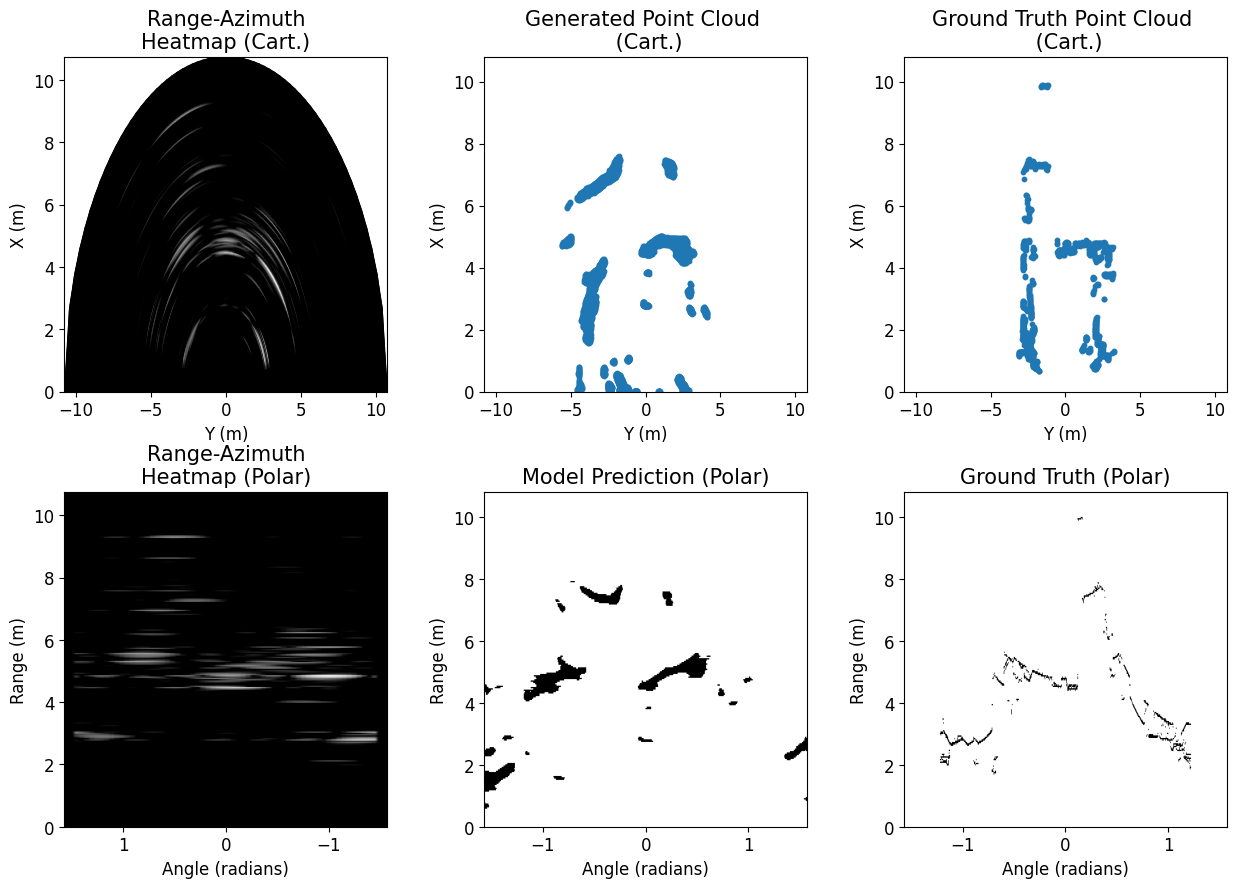

In [6]:
plotter.plot_compilation(
    adc_cube=adc_cube,
    input_encoder=input_encoder,
    model_runner=runner,
    prediction_decoder=prediction_decoder,
    lidar_pc=lidar_pc,
    ground_truth_encoder=ground_truth_encoder,
    axs=[],
    show=True
)

In [7]:
chamfer,hausdorff, chamfer_radarHD, modified_hausdorff_radarHD = \
    analyzer.compute_all_distance_metrics(
        save_to_file=True,
        file_name=dataset_name
    )
analyzer.show_all_summary_statistics(
    chamfer_distances=chamfer,
    hausdorff_distances=hausdorff,
    chamfer_distances_radarHD=chamfer_radarHD,
    modified_hausdorff_distances_radarHD=modified_hausdorff_radarHD
)

Analyzer.compute_all_distance_metrics: Computing distance metrics


100%|██████████| 262/262 [00:34<00:00,  7.62it/s]

Analyzer.compute_all_distance_metrics: number failed predictoins 0 of 262 (0.0%)


,Metric,Hausdorff,Modified Hausdorff (radarHD),Chamfer,Chamfer (radarHD)
0,Mean,4.007470,0.420449,1.343001,0.514820
1,Median,3.802454,0.350162,1.223912,0.500112
2,90th percentile,5.756930,0.676812,1.936418,0.662259


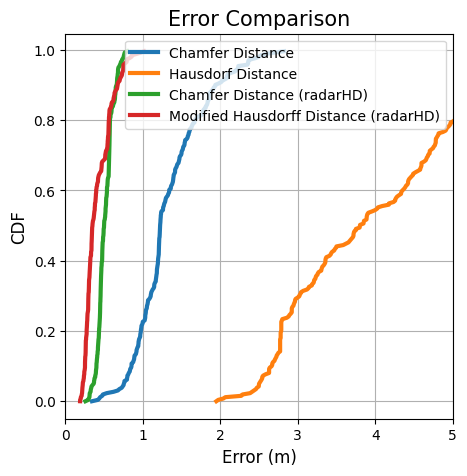

In [8]:
plotter.plot_distance_metrics_cdfs(
    chamfer_distances=chamfer,
    hausdorf_distances=hausdorff,
    chamfer_distances_radarHD=chamfer_radarHD,
    modified_hausdorf_distances_radarHD=modified_hausdorff_radarHD
)

100%|██████████| 262/262 [00:17<00:00, 15.34it/s]


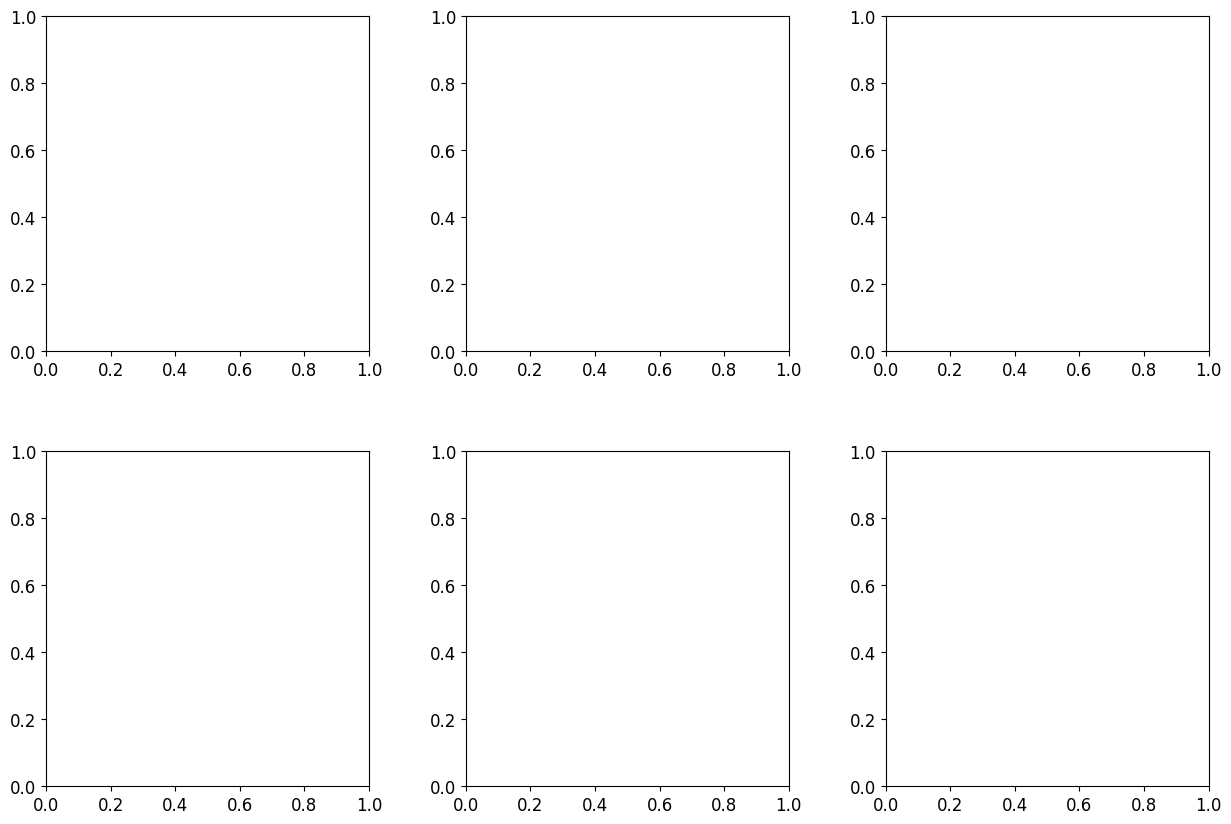

In [9]:
movie_generator.initialize_figure(
    nrows=2,
    ncols=3,
    figsize=(15,10),
    wspace=0.3,
    hspace=0.3
)

movie_generator.generate_movie_frames()

fps = 1 / (1e-3 * cfg_manager.frameCfg_periodicity_ms)
movie_generator.save_movie(video_file_name="{}.mp4".format(dataset_name),fps=fps)